# PCA-Based Statistical Arbitrage: Multi-Strategy Comparison



Compare 4 strategy variants:

1. **Continuous Rebalancing + PCA & ETF Hedge** (No Transaction Cost)

2. **Continuous Rebalancing + ETF-Only Hedge** (No Transaction Cost)

3. **Fixed Position + ETF Hedge** (No Transaction Cost)

4. **Fixed Position + ETF Hedge** (Transaction Cost = 3 bps)

>>> Downloading data...



2 Failed downloads:
['ANSS', 'JNPR']: YFTzMissingError('possibly delisted; no timezone found')



>>> Running: Continuous Rebalancing + PCA & ETF Hedge (No Cost)
    Final NAV:       $1,973,036.98
    Total Return:    97.30%
    Ann. Return:     7.87%
    Ann. Volatility: 5.43%
    Sharpe Ratio:    1.42
    Max Drawdown:    -5.01%
    Total Cost:      $0.00

>>> Running: Continuous Rebalancing + ETF-Only Hedge (No Cost)
    Final NAV:       $2,026,963.53
    Total Return:    102.70%
    Ann. Return:     8.19%
    Ann. Volatility: 5.64%
    Sharpe Ratio:    1.42
    Max Drawdown:    -5.50%
    Total Cost:      $0.00

>>> Running: Fixed Position + ETF Hedge (No Cost)
    Final NAV:       $3,832,864.71
    Total Return:    283.29%
    Ann. Return:     16.15%
    Ann. Volatility: 9.68%
    Sharpe Ratio:    1.60
    Max Drawdown:    -8.64%
    Total Cost:      $0.00

>>> Running: Fixed Position + ETF Hedge (TC = 3 bps)
    Final NAV:       $1,855,699.17
    Total Return:    85.57%
    Ann. Return:     7.13%
    Ann. Volatility: 9.69%
    Sharpe Ratio:    0.76
    Max Drawdown:    -11.3

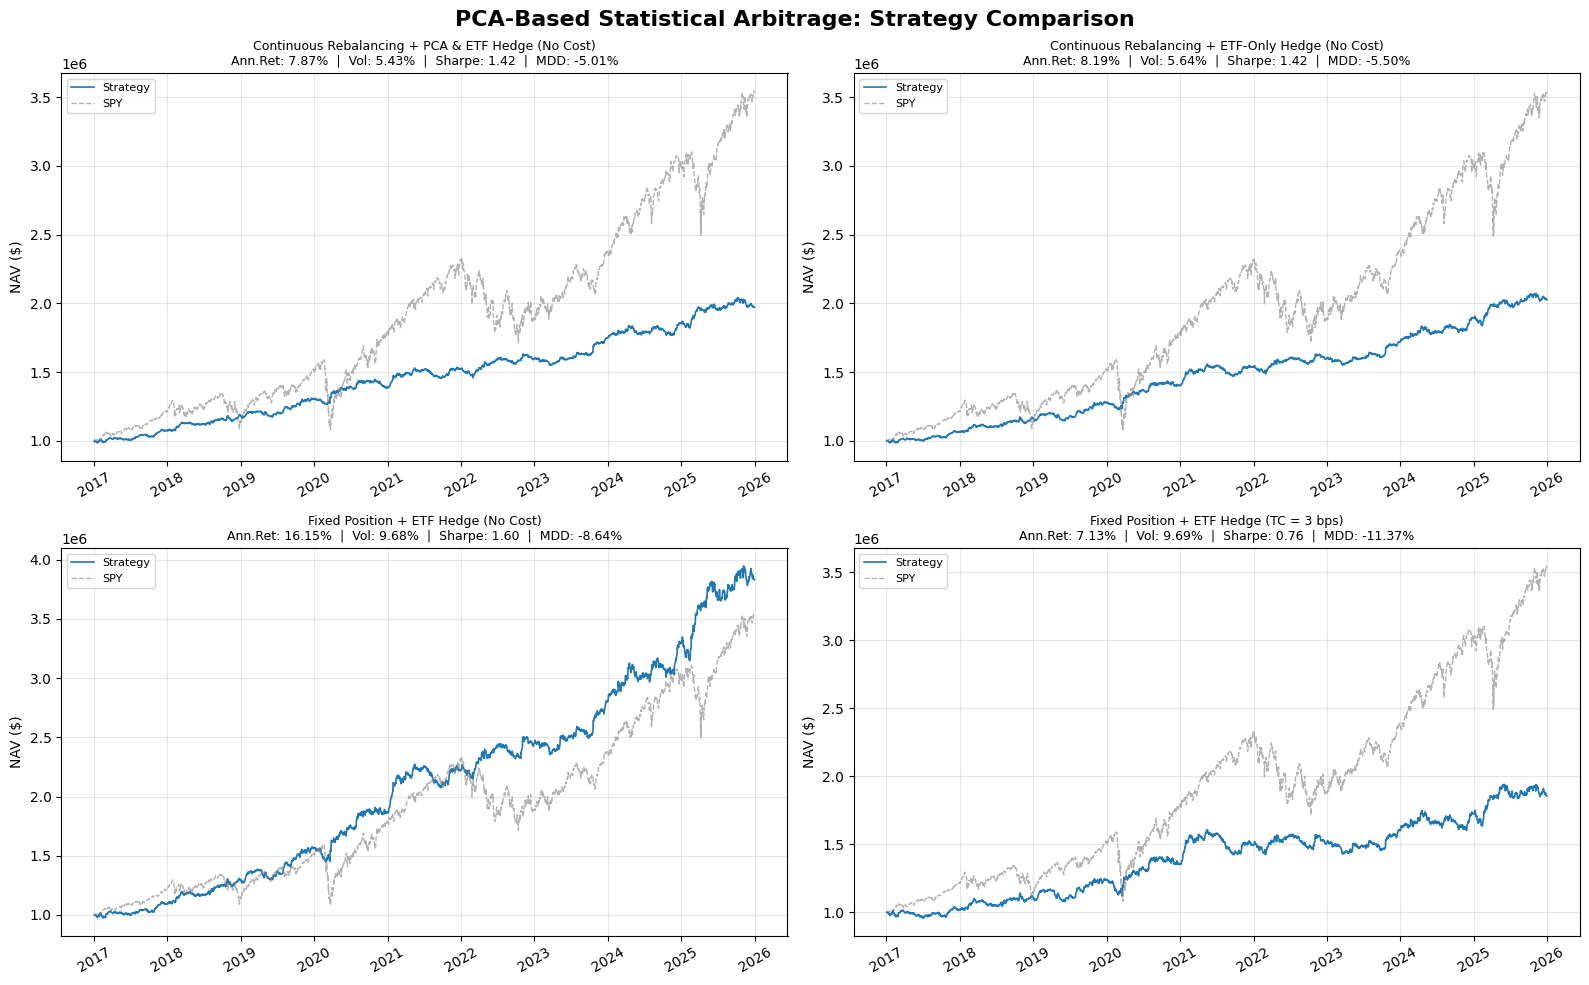

In [47]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')

# ==========================================
# 1. Configuration
# ==========================================
START_DATE = '2016-01-01'
END_DATE = '2025-12-31'
BACKTEST_START = '2017-01-01'

INITIAL_CAPITAL = 1_000_000.0
MAX_LEVERAGE = 1.0
ENTRY_PCT = 80.0
EXIT_THRES = 0.75
STOP_LOSS_THRES = 3.3

N_COMPONENTS = 2
LOOKBACK_WINDOW = 252
OU_WINDOW = 63
REGIME_LEN = 63
HL_MIN, HL_MAX = 1.0, 60.0
FIXED_UNIT_SIZE = 50_000.0  # Fixed dollar amount per position (for fixed-unit mode)
MAX_NET_LEVERAGE = 2.0       # Max |net exposure| as multiple of NAV

TICKERS = [
    'AAPL','MSFT','NVDA','AVGO','ORCL','CRM','AMD','CSCO','ACN','ADBE',
    'IBM','TXN','QCOM','INTU','AMAT','NOW','PANW','ADI','MU','LRCX',
    'KLAC','SNPS','CDNS','MCHP','FTNT','MSI','APH','NXPI','ROP','KEYS',
    'ON','MPWR','FSLR','IT','TEL','ZBRA','TYL','TRMB','PTC','ANSS',
    'CDW','SWKS','GEN','EPAM','AKAM','JNPR','FFIV','QRVO','ENPH','SEDG',
    'HPQ','HPE','WDC','STX','NTAP','GLW','VRSN','CTSH','PAYC','DELL',
    'ANET','CRWD','PLTR','GDDY','FICO'
]
FACTORS = ['SPY', 'XLK']

# Define 4 strategy variants for comparative backtest
STRATEGIES = [
    {'name': 'Continuous Rebalancing + PCA & ETF Hedge (No Cost)',
     'position_mode': 'continuous', 'hedge_mode': 'pca_etf', 'tc_rate': 0.0},
    {'name': 'Continuous Rebalancing + ETF-Only Hedge (No Cost)',
     'position_mode': 'continuous', 'hedge_mode': 'etf_only', 'tc_rate': 0.0},
    {'name': 'Fixed Position + ETF Hedge (No Cost)',
     'position_mode': 'fixed_unit', 'hedge_mode': 'etf_only', 'tc_rate': 0.0},
    {'name': 'Fixed Position + ETF Hedge (TC = 3 bps)',
     'position_mode': 'fixed_unit', 'hedge_mode': 'etf_only', 'tc_rate': 0.0003},
]

# ==========================================
# 2. Data Loading
# ==========================================
def get_clean_data(tickers, factors, start, end):
    """Download and clean daily open prices from Yahoo Finance."""
    print(">>> Downloading data...")
    all_syms = list(set(tickers + factors))
    df = yf.download(all_syms, start=start, end=end, auto_adjust=True,
                     progress=False, threads=True)

    if isinstance(df.columns, pd.MultiIndex):
        try:
            prices = df['Open']
        except KeyError:
            prices = df.xs('Open', axis=1, level=0)
    else:
        prices = df['Open']

    prices = prices.dropna(axis=1, how='all').ffill().bfill()
    prices.index = pd.to_datetime(prices.index).tz_localize(None)
    valid_stocks = [t for t in tickers if t in prices.columns]
    return prices[valid_stocks], prices[factors]

df_stock, df_factor = get_clean_data(TICKERS, FACTORS, START_DATE, END_DATE)

# ==========================================
# 3. Regime Model (PCA + OU)
# ==========================================
class RegimeParams:
    """Container for PCA-based regime model parameters."""
    def __init__(self):
        self.all_tickers = []
        self.valid_tickers = []
        self.pca_comps = None     # PCA loading matrix W, shape (K, N)
        self.pca_mean = None
        self.pca_std = None
        self.betas = None         # Factor betas for SPY and XLK
        self.gamma = None         # Residual-to-factor loading matrix, shape (N, K)
        self.ou_params = None     # OU process parameters per stock


def train_regime_model(h_stock, h_factor, prev_params=None):
    """
    Train PCA + OU regime model.
    Pipeline: factor regression -> PCA on standardized residuals -> OU fit.
    """
    ret_stock = np.log(h_stock / h_stock.shift(1)).iloc[1:].fillna(0)
    ret_factor = np.log(h_factor / h_factor.shift(1)).iloc[1:].fillna(0)
    if len(ret_stock) < LOOKBACK_WINDOW * 0.9:
        return None

    all_tickers = ret_stock.columns.tolist()
    X_vals = sm.add_constant(ret_factor).values
    Y_vals = ret_stock.values

    try:
        beta_mat = np.linalg.inv(X_vals.T @ X_vals) @ (X_vals.T @ Y_vals)
    except np.linalg.LinAlgError:
        return None

    betas = pd.DataFrame(beta_mat.T, index=all_tickers,
                         columns=['alpha', 'beta_SPY', 'beta_XLK'])
    U_vals = Y_vals - (X_vals @ beta_mat)

    # PCA on standardized residuals
    scaler = StandardScaler()
    U_std_vals = scaler.fit_transform(U_vals)
    pca = PCA(n_components=N_COMPONENTS)
    pca.fit(U_std_vals)
    current_comps = pca.components_

    # Align PCA sign with previous regime to avoid arbitrary flips
    if prev_params and prev_params.pca_comps is not None:
        for k in range(N_COMPONENTS):
            if np.dot(current_comps[k], prev_params.pca_comps[k]) < 0:
                current_comps[k] = -current_comps[k]

    # Factor scores and residual loadings
    F = U_std_vals @ current_comps.T
    gamma_mat = np.linalg.inv(F.T @ F) @ (F.T @ U_std_vals)
    gamma_df = pd.DataFrame(gamma_mat.T, index=all_tickers,
                            columns=[f'g{i+1}' for i in range(N_COMPONENTS)])

    # Idiosyncratic residuals
    Eps_df = pd.DataFrame(U_std_vals - (F @ gamma_mat),
                          index=ret_stock.index, columns=all_tickers)

    # OU parameter estimation on recent cumulative residuals
    recent_eps = Eps_df.iloc[-OU_WINDOW:].cumsum()
    candidates = []

    for tkr in all_tickers:
        x = recent_eps[tkr].values
        if np.std(x) < 1e-6:
            continue
        lag, curr = x[:-1], x[1:]
        try:
            res = sm.OLS(curr, sm.add_constant(lag)).fit()
            b = res.params[1]
            if b >= 0.999:
                continue
            kappa = -np.log(b)
            hl = np.log(2) / kappa
            if hl < HL_MIN or hl > HL_MAX:
                continue
            mu = res.params[0] / (1 - b)
            sig = np.std(res.resid) / np.sqrt(1 - b ** 2)
            hist_z = (x - mu) / sig
            dyn_entry = np.clip(np.percentile(np.abs(hist_z), ENTRY_PCT), 1.0, 2.5)
            candidates.append({'ticker': tkr, 'mu': mu, 'sigma_eq': sig,
                               'entry_thres': dyn_entry})
        except:
            continue

    if not candidates:
        return None
    cand_df = pd.DataFrame(candidates).set_index('ticker')

    params = RegimeParams()
    params.all_tickers = all_tickers
    params.valid_tickers = cand_df.index.tolist()
    params.pca_comps = current_comps
    params.pca_mean = pd.Series(scaler.mean_, index=all_tickers)
    params.pca_std = pd.Series(scaler.scale_, index=all_tickers)
    params.betas = betas[['beta_SPY', 'beta_XLK']]
    params.gamma = gamma_df
    params.ou_params = cand_df
    return params

# ==========================================
# 4. Unified Backtest Engine
# ==========================================
def run_backtest(df_stock, df_factor, tickers, config):
    """
    Run a single backtest with the given strategy configuration.

    Parameters
    ----------
    config : dict
        position_mode : 'continuous' (equal-weight daily rebalancing)
                        or 'fixed_unit' (fixed dollar allocation, no rebalancing)
        hedge_mode    : 'pca_etf' (PCA-replicated + ETF beta hedge)
                        or 'etf_only' (ETF beta hedge only)
        tc_rate       : transaction cost rate (e.g. 0.0003 for 3 bps)
        name          : strategy label for display

    Returns
    -------
    pd.DataFrame with 'NAV' column indexed by date.
    """
    dates = df_stock[BACKTEST_START:].index
    position_mode = config['position_mode']
    hedge_mode = config.get('hedge_mode', 'etf_only')
    tc_rate = config.get('tc_rate', 0.0)

    # State variables
    curr_model = None
    regime_age = 0
    x_state = pd.Series(0.0, index=tickers)
    pos_state = pd.Series(0.0, index=tickers)    # Signal direction: -1, 0, +1
    share_state = pd.Series(0.0, index=tickers)  # Share count (fixed_unit mode only)

    nav = INITIAL_CAPITAL
    nav_history = []
    cum_cost = 0.0

    for i in range(len(dates)):
        today = dates[i]
        nav_history.append(nav)
        if i == 0:
            continue

        # --- Regime re-calibration ---
        if curr_model is None or regime_age >= REGIME_LEN:
            loc_idx = df_stock.index.get_loc(today)
            if loc_idx > LOOKBACK_WINDOW:
                train_stock = df_stock.iloc[loc_idx - LOOKBACK_WINDOW: loc_idx]
                train_factor = df_factor.iloc[loc_idx - LOOKBACK_WINDOW: loc_idx]
                new_model = train_regime_model(train_stock, train_factor, curr_model)
                if new_model:
                    curr_model = new_model
                    regime_age = 0
                    x_state[:] = 0.0
                    # Reset positions on regime change only in continuous mode
                    if position_mode == 'continuous':
                        pos_state[:] = 0.0
        regime_age += 1

        if curr_model is None:
            continue

        # --- OU signal generation ---
        prev = dates[i - 1]
        all_tkr = curr_model.all_tickers
        valid_tkr = curr_model.valid_tickers

        p_today = df_stock.loc[today, all_tkr].ffill()
        p_prev = df_stock.loc[prev, all_tkr].ffill()
        f_today = df_factor.loc[today]
        f_prev = df_factor.loc[prev]

        r_stock = np.log((p_today + 1e-9) / (p_prev + 1e-9)).fillna(0)
        r_spy = np.log((f_today['SPY'] + 1e-9) / (f_prev['SPY'] + 1e-9))
        r_xlk = np.log((f_today['XLK'] + 1e-9) / (f_prev['XLK'] + 1e-9))

        # Factor-adjusted standardized residuals
        b_spy = curr_model.betas.loc[all_tkr, 'beta_SPY']
        b_xlk = curr_model.betas.loc[all_tkr, 'beta_XLK']
        u = r_stock - (b_spy * r_spy + b_xlk * r_xlk)
        u_std = (u - curr_model.pca_mean) / curr_model.pca_std
        f_vals = curr_model.pca_comps @ u_std.values

        # Cumulative idiosyncratic residual (OU state variable)
        eps_valid_z = u_std[valid_tkr] - (curr_model.gamma.loc[valid_tkr].values @ f_vals)
        x_new = x_state[valid_tkr] + eps_valid_z
        x_state[valid_tkr] = x_new

        # S-score from OU process
        mu = curr_model.ou_params['mu']
        sig = curr_model.ou_params['sigma_eq']
        dyn_entries = curr_model.ou_params['entry_thres']
        s_score = (x_new - mu) / sig

        # --- Entry / exit / stop-loss rules ---
        curr_pos = pos_state[valid_tkr].copy()
        new_pos = curr_pos.copy()
        new_pos[s_score > dyn_entries] = -1.0        # Short when s-score too high
        new_pos[s_score < -dyn_entries] = 1.0         # Long when s-score too low
        new_pos[(curr_pos == -1.0) & (s_score < EXIT_THRES)] = 0.0   # Close short
        new_pos[(curr_pos == 1.0) & (s_score > -EXIT_THRES)] = 0.0   # Close long
        new_pos[(curr_pos == -1.0) & (s_score > STOP_LOSS_THRES)] = 0.0  # Stop loss
        new_pos[(curr_pos == 1.0) & (s_score < -STOP_LOSS_THRES)] = 0.0  # Stop loss

        # --- Net exposure cap: |net_notional| ≤ MAX_NET_LEVERAGE × NAV ---
        if position_mode == 'fixed_unit':
            active_idx = new_pos[new_pos != 0].index
            net_pos = new_pos[active_idx].sum()   # +1 per long, -1 per short
            max_net = MAX_NET_LEVERAGE / (FIXED_UNIT_SIZE / INITIAL_CAPITAL)

            if net_pos > max_net:
                # Net-long exceeds cap → trim weakest longs
                n_drop = int(np.ceil(net_pos - max_net))
                long_idx = new_pos[new_pos == 1.0].index
                existing_longs = long_idx.intersection(
                    curr_pos[curr_pos == 1.0].index)
                new_longs = long_idx.difference(existing_longs)
                # Drop weakest new entries first, then weakest existing
                ranked = pd.concat([
                    s_score[new_longs].abs().sort_values(),
                    s_score[existing_longs].abs().sort_values()])
                new_pos[ranked.index[:n_drop]] = 0.0

            elif net_pos < -max_net:
                # Net-short exceeds cap → trim weakest shorts
                n_drop = int(np.ceil(-net_pos - max_net))
                short_idx = new_pos[new_pos == -1.0].index
                existing_shorts = short_idx.intersection(
                    curr_pos[curr_pos == -1.0].index)
                new_shorts = short_idx.difference(existing_shorts)
                ranked = pd.concat([
                    s_score[new_shorts].abs().sort_values(),
                    s_score[existing_shorts].abs().sort_values()])
                new_pos[ranked.index[:n_drop]] = 0.0

        pos_state[valid_tkr] = new_pos

        # --- PnL computation ---
        daily_pnl = 0.0
        if i >= len(dates) - 1:
            continue

        next_d = dates[i + 1]
        p_next = df_stock.loc[next_d, all_tkr].ffill()
        f_next = df_factor.loc[next_d]

        if position_mode == 'continuous':
            # ---- Continuous rebalancing: equal-weight among active signals ----
            active_mask = (new_pos != 0.0)
            active_tkrs = new_pos.index[active_mask]

            # Target weights: 0 if no active signals, else equal-weight
            net_stock_weights = pd.Series(0.0, index=all_tkr)

            if len(active_tkrs) > 0:
                raw_weights = pd.Series(0.0, index=all_tkr)
                base_alloc = (1.0 / len(active_tkrs)) * MAX_LEVERAGE
                raw_weights[active_tkrs] = new_pos[active_tkrs] * base_alloc

                if hedge_mode == 'pca_etf':
                    port_gamma = raw_weights.values @ curr_model.gamma.values
                    pca_hedge_weights = port_gamma @ curr_model.pca_comps
                    net_stock_weights = pd.Series(
                        raw_weights.values - pca_hedge_weights, index=all_tkr)
                else:
                    net_stock_weights = raw_weights

                # ETF beta hedge
                port_beta_spy = (net_stock_weights * curr_model.betas['beta_SPY']).sum()
                port_beta_xlk = (net_stock_weights * curr_model.betas['beta_XLK']).sum()

                # T+1 log returns for PnL settlement
                r_n_stock = np.log((p_next + 1e-9) / (p_today + 1e-9)).fillna(0)
                r_n_spy = np.log((f_next['SPY'] + 1e-9) / (f_today['SPY'] + 1e-9))
                r_n_xlk = np.log((f_next['XLK'] + 1e-9) / (f_today['XLK'] + 1e-9))

                pnl_stocks = (net_stock_weights * r_n_stock).sum() * nav
                pnl_hedge_spy = port_beta_spy * r_n_spy * nav
                pnl_hedge_xlk = port_beta_xlk * r_n_xlk * nav
                daily_pnl = pnl_stocks - pnl_hedge_spy - pnl_hedge_xlk

        elif position_mode == 'fixed_unit':
            # ---- Fixed-unit execution: trade only on signal changes ----
            # Scale unit size with NAV (compounding effect)
            unit_size = nav * (FIXED_UNIT_SIZE / INITIAL_CAPITAL)

            current_prices = p_today[valid_tkr]
            prev_shares = share_state[valid_tkr].copy()
            new_shares = prev_shares.copy()

            # Detect signal transitions
            entry_mask = (curr_pos == 0.0) & (new_pos != 0.0)   # New entry
            exit_mask = (curr_pos != 0.0) & (new_pos == 0.0)    # Exit
            flip_mask = ((curr_pos != 0.0) & (new_pos != 0.0)
                         & (curr_pos != new_pos))                # Reversal

            if entry_mask.any():
                tkrs = entry_mask[entry_mask].index
                new_shares[tkrs] = (new_pos[tkrs] * unit_size
                                    / current_prices[tkrs])
            if exit_mask.any():
                new_shares[exit_mask[exit_mask].index] = 0.0
            if flip_mask.any():
                tkrs = flip_mask[flip_mask].index
                new_shares[tkrs] = (new_pos[tkrs] * unit_size
                                    / current_prices[tkrs])

            share_state[valid_tkr] = new_shares

            # Force-close orphaned positions (tickers dropped from valid universe)
            orphan_mask = (share_state != 0) & (~share_state.index.isin(valid_tkr))
            share_state[orphan_mask] = 0.0
            pos_state[orphan_mask] = 0.0

            # Portfolio dollar-beta for ETF hedge (only active tickers)
            curr_share_val = share_state * p_today.reindex(tickers, fill_value=0.0)
            port_dollar_beta_spy = (curr_share_val * curr_model.betas.reindex(
                tickers, fill_value=0.0)['beta_SPY']).sum()
            port_dollar_beta_xlk = (curr_share_val * curr_model.betas.reindex(
                tickers, fill_value=0.0)['beta_XLK']).sum()

            # Stock PnL (share-based, T to T+1)
            price_diff = p_next.reindex(tickers, fill_value=0.0) - \
                         p_today.reindex(tickers, fill_value=0.0)
            pnl_stocks = (share_state * price_diff).sum()

            # ETF hedge PnL (simple returns)
            r_n_spy = (f_next['SPY'] - f_today['SPY']) / f_today['SPY']
            r_n_xlk = (f_next['XLK'] - f_today['XLK']) / f_today['XLK']
            pnl_hedge_spy = -port_dollar_beta_spy * r_n_spy
            pnl_hedge_xlk = -port_dollar_beta_xlk * r_n_xlk

            # Transaction cost on changed shares
            delta_shares = (new_shares - prev_shares).abs()
            cost = (delta_shares * current_prices).sum() * tc_rate

            daily_pnl = pnl_stocks + pnl_hedge_spy + pnl_hedge_xlk - cost
            cum_cost += cost

        nav += daily_pnl

    nav_df = pd.DataFrame({'NAV': nav_history}, index=dates)
    return nav_df, cum_cost

# ==========================================
# 5. Run All Strategies
# ==========================================
results = {}
for strat in STRATEGIES:
    label = strat['name']
    print(f"\n>>> Running: {label}")
    df_result, cum_cost = run_backtest(df_stock, df_factor, TICKERS, strat)

    n_years = len(df_result) / 252
    total_ret = (df_result['NAV'].iloc[-1] / INITIAL_CAPITAL) - 1.0
    ann_ret = (df_result['NAV'].iloc[-1] / INITIAL_CAPITAL) ** (1 / n_years) - 1.0
    daily_ret = df_result['NAV'].pct_change().fillna(0)
    ann_vol = daily_ret.std() * np.sqrt(252)
    sharpe = (daily_ret.mean() / daily_ret.std()) * np.sqrt(252) if daily_ret.std() > 0 else 0

    # Max drawdown
    cummax = df_result['NAV'].cummax()
    drawdown = (df_result['NAV'] - cummax) / cummax
    max_dd = drawdown.min()

    results[label] = {
        'nav': df_result,
        'total_return': total_ret,
        'ann_return': ann_ret,
        'ann_vol': ann_vol,
        'sharpe': sharpe,
        'max_drawdown': max_dd,
        'cum_cost': cum_cost,
    }
    print(f"    Final NAV:       ${df_result['NAV'].iloc[-1]:,.2f}")
    print(f"    Total Return:    {total_ret*100:.2f}%")
    print(f"    Ann. Return:     {ann_ret*100:.2f}%")
    print(f"    Ann. Volatility: {ann_vol*100:.2f}%")
    print(f"    Sharpe Ratio:    {sharpe:.2f}")
    print(f"    Max Drawdown:    {max_dd*100:.2f}%")
    print(f"    Total Cost:      ${cum_cost:,.2f}")

# ==========================================
# 6. Comparative Visualization (2x2)
# ==========================================
# SPY benchmark NAV (normalized to same starting capital)
spy_bt = df_factor['SPY'][BACKTEST_START:]
spy_nav = INITIAL_CAPITAL * (spy_bt / spy_bt.iloc[0])

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('PCA-Based Statistical Arbitrage: Strategy Comparison',
             fontsize=16, fontweight='bold')

for ax, (label, res) in zip(axes.flatten(), results.items()):
    nav_series = res['nav']['NAV']
    ax.plot(nav_series.index, nav_series.values, linewidth=1.2, label='Strategy')
    ax.plot(spy_nav.index, spy_nav.values, linewidth=1.0, color='gray',
            alpha=0.6, linestyle='--', label='SPY')
    ax.set_title(f"{label}\n"
                 f"Ann.Ret: {res['ann_return']*100:.2f}%  |  "
                 f"Vol: {res['ann_vol']*100:.2f}%  |  "
                 f"Sharpe: {res['sharpe']:.2f}  |  "
                 f"MDD: {res['max_drawdown']*100:.2f}%",
                 fontsize=9)
    ax.set_ylabel('NAV ($)')
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

  Kalman Filter Beta — Full Backtest Comparison

>>> Running (KF): Continuous Rebalancing + PCA & ETF Hedge (No Cost)
    Final NAV:       $1,524,682.76
    Total Return:    52.47%
    Ann. Return:     4.81%
    Ann. Volatility: 5.78%
    Sharpe Ratio:    0.84
    Max Drawdown:    -8.81%
    Total Cost:      $0.00

>>> Running (KF): Continuous Rebalancing + ETF-Only Hedge (No Cost)
    Final NAV:       $1,495,378.64
    Total Return:    49.54%
    Ann. Return:     4.59%
    Ann. Volatility: 5.96%
    Sharpe Ratio:    0.78
    Max Drawdown:    -9.07%
    Total Cost:      $0.00

>>> Running (KF): Fixed Position + ETF Hedge (No Cost)
    Final NAV:       $1,875,995.09
    Total Return:    87.60%
    Ann. Return:     7.26%
    Ann. Volatility: 9.92%
    Sharpe Ratio:    0.76
    Max Drawdown:    -15.69%
    Total Cost:      $0.00

>>> Running (KF): Fixed Position + ETF Hedge (TC = 3 bps)
    Final NAV:       $955,629.61
    Total Return:    -4.44%
    Ann. Return:     -0.50%
    Ann. Volat

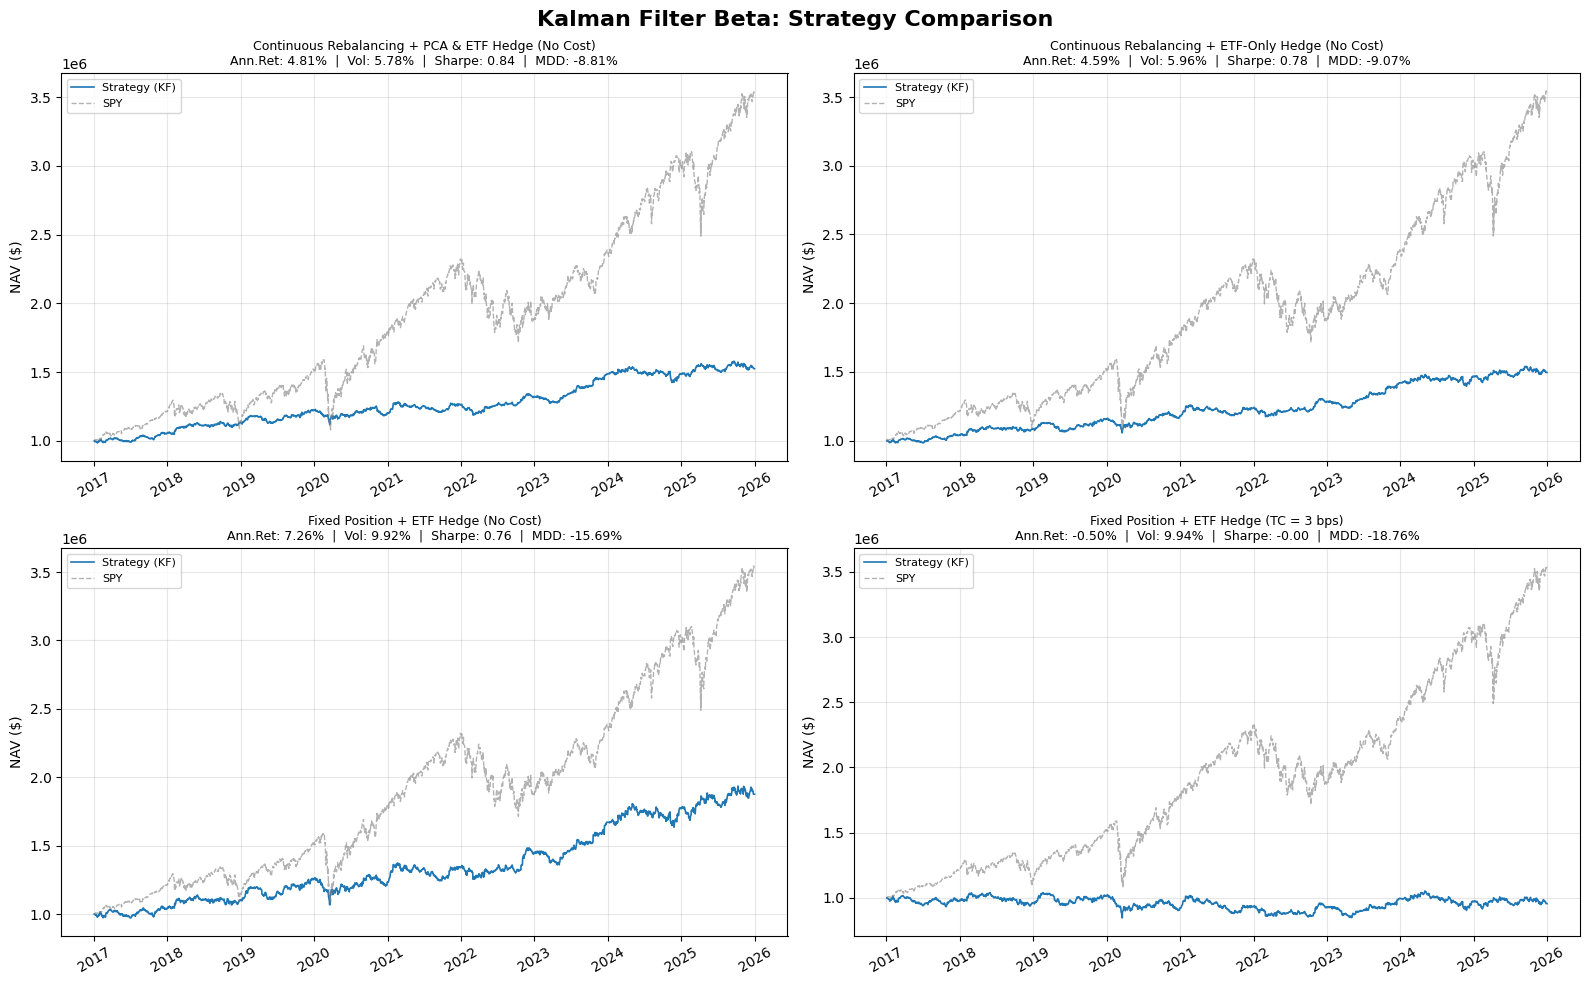

In [48]:
# ==========================================
# Kalman Filter Beta Estimation: Full Backtest
# ==========================================
# This cell replaces OLS moving-window beta with a Kalman filter.
# Key design: beta_{t|t-1} (predicted BEFORE seeing today's data)
#   is used for signal generation / hedging to avoid look-ahead bias.
# Timeline per day:
#   1. PREDICT  ->  beta_{t|t-1}  (data up to t-1 only)
#   2. Use beta_{t|t-1} for residual / signal / hedge
#   3. UPDATE   ->  beta_{t|t}    (stored for tomorrow's PREDICT)

KALMAN_DELTA = 1e-4  # State transition noise scaling: Q = delta * R * I

# ------------------------------------------------------------------
# Kalman Filter initialization via OLS warm-start
# ------------------------------------------------------------------
def kf_init_ols(h_stock, h_factor, tkr_list):
    """
    Initialize Kalman states using OLS on historical window.
    State vector: [alpha, beta_SPY, beta_XLK]
    Observation model: r_stock_t = [1, r_SPY_t, r_XLK_t] @ beta + eps
    Returns dict: ticker -> {beta, P, R, Q}
    """
    ret_s = np.log(h_stock / h_stock.shift(1)).iloc[1:].fillna(0)
    ret_f = np.log(h_factor / h_factor.shift(1)).iloc[1:].fillna(0)
    X = sm.add_constant(ret_f).values

    states = {}
    for tkr in tkr_list:
        if tkr not in ret_s.columns:
            continue
        y = ret_s[tkr].values
        try:
            ols = sm.OLS(y, X).fit()
            R = float(np.var(ols.resid))
            if R < 1e-12:
                R = 1e-6
            states[tkr] = {
                'beta': ols.params.copy(),         # [alpha, b_SPY, b_XLK]
                'P':    R * np.eye(3) * 10.0,      # State covariance (wide prior)
                'R':    R,                          # Observation noise variance
                'Q':    KALMAN_DELTA * R * np.eye(3),  # State transition noise
            }
        except Exception:
            continue
    return states

# ------------------------------------------------------------------
# Regime model using external (Kalman) betas
# ------------------------------------------------------------------
def train_regime_model_kf(h_stock, h_factor, kf_betas_df, prev_params=None):
    """
    Same pipeline as train_regime_model (PCA + OU) but uses externally
    provided betas from the Kalman filter instead of in-sample OLS.
    kf_betas_df: DataFrame, index=tickers, columns=[alpha, beta_SPY, beta_XLK]
    """
    ret_stock = np.log(h_stock / h_stock.shift(1)).iloc[1:].fillna(0)
    ret_factor = np.log(h_factor / h_factor.shift(1)).iloc[1:].fillna(0)
    if len(ret_stock) < LOOKBACK_WINDOW * 0.9:
        return None

    all_tickers = [t for t in ret_stock.columns if t in kf_betas_df.index]
    if len(all_tickers) < 10:
        return None
    ret_stock = ret_stock[all_tickers]

    # Compute residuals using Kalman betas (applied uniformly to whole window,
    # same approximation as OLS which uses one set of betas for the window)
    X_vals = sm.add_constant(ret_factor).values            # (T, 3)
    beta_mat = kf_betas_df.loc[all_tickers].values         # (N, 3)
    U_vals = ret_stock.values - X_vals @ beta_mat.T        # (T, N)

    # PCA on standardized residuals
    scaler = StandardScaler()
    U_std_vals = scaler.fit_transform(U_vals)
    pca = PCA(n_components=N_COMPONENTS)
    pca.fit(U_std_vals)
    current_comps = pca.components_

    if prev_params and prev_params.pca_comps is not None:
        for k in range(N_COMPONENTS):
            if np.dot(current_comps[k], prev_params.pca_comps[k]) < 0:
                current_comps[k] = -current_comps[k]

    F = U_std_vals @ current_comps.T
    gamma_mat = np.linalg.inv(F.T @ F) @ (F.T @ U_std_vals)
    gamma_df = pd.DataFrame(gamma_mat.T, index=all_tickers,
                            columns=[f'g{i+1}' for i in range(N_COMPONENTS)])

    Eps_df = pd.DataFrame(U_std_vals - (F @ gamma_mat),
                          index=ret_stock.index, columns=all_tickers)

    # OU parameter estimation on recent cumulative residuals
    recent_eps = Eps_df.iloc[-OU_WINDOW:].cumsum()
    candidates = []
    for tkr in all_tickers:
        x = recent_eps[tkr].values
        if np.std(x) < 1e-6:
            continue
        lag, curr = x[:-1], x[1:]
        try:
            res = sm.OLS(curr, sm.add_constant(lag)).fit()
            b = res.params[1]
            if b >= 0.999:
                continue
            kappa = -np.log(b)
            hl = np.log(2) / kappa
            if hl < HL_MIN or hl > HL_MAX:
                continue
            mu_ou = res.params[0] / (1 - b)
            sig_ou = np.std(res.resid) / np.sqrt(1 - b ** 2)
            hist_z = (x - mu_ou) / sig_ou
            dyn_entry = np.clip(np.percentile(np.abs(hist_z), ENTRY_PCT), 1.0, 2.5)
            candidates.append({'ticker': tkr, 'mu': mu_ou, 'sigma_eq': sig_ou,
                               'entry_thres': dyn_entry})
        except Exception:
            continue

    if not candidates:
        return None
    cand_df = pd.DataFrame(candidates).set_index('ticker')

    params = RegimeParams()
    params.all_tickers = all_tickers
    params.valid_tickers = cand_df.index.tolist()
    params.pca_comps = current_comps
    params.pca_mean = pd.Series(scaler.mean_, index=all_tickers)
    params.pca_std = pd.Series(scaler.scale_, index=all_tickers)
    params.betas = kf_betas_df.loc[all_tickers, ['beta_SPY', 'beta_XLK']]
    params.gamma = gamma_df
    params.ou_params = cand_df
    return params


# ------------------------------------------------------------------
# Backtest engine with Kalman Filter betas
# ------------------------------------------------------------------
def run_backtest_kf(df_stock, df_factor, tickers, config):
    """
    Backtest with Kalman-filtered dynamic beta estimation.
    Uses predict-then-update to strictly avoid look-ahead bias:
      - PREDICT gives beta_{t|t-1} (only past data)
      - Signal & hedge use beta_{t|t-1}
      - UPDATE incorporates today's observation -> beta_{t|t}
    """
    dates = df_stock[BACKTEST_START:].index
    position_mode = config['position_mode']
    hedge_mode = config.get('hedge_mode', 'etf_only')
    tc_rate = config.get('tc_rate', 0.0)

    avail_tickers = [t for t in tickers if t in df_stock.columns]

    # ---- Kalman warm-start: OLS initialization ----
    bt_start_idx = df_stock.index.get_loc(dates[0])
    init_end = min(LOOKBACK_WINDOW, bt_start_idx)

    kf_states = kf_init_ols(
        df_stock.iloc[:init_end][avail_tickers],
        df_factor.iloc[:init_end],
        avail_tickers
    )
    kf_tickers = list(kf_states.keys())

    # Warm-up: run Kalman forward through remaining pre-backtest data
    for t_idx in range(init_end + 1, bt_start_idx):
        p_t = df_stock.iloc[t_idx].reindex(kf_tickers).ffill().fillna(0)
        p_prev = df_stock.iloc[t_idx - 1].reindex(kf_tickers).ffill().fillna(0)
        f_t = df_factor.iloc[t_idx]
        f_prev = df_factor.iloc[t_idx - 1]

        r_s = np.log((p_t + 1e-9) / (p_prev + 1e-9)).fillna(0)
        r_spy_w = np.log((f_t['SPY'] + 1e-9) / (f_prev['SPY'] + 1e-9))
        r_xlk_w = np.log((f_t['XLK'] + 1e-9) / (f_prev['XLK'] + 1e-9))
        H_w = np.array([1.0, r_spy_w, r_xlk_w])

        for tkr in kf_tickers:
            s = kf_states[tkr]
            P_pred = s['P'] + s['Q']
            x_pred = s['beta']
            y_obs = r_s.get(tkr, 0.0) if hasattr(r_s, 'get') else r_s[tkr]
            e = y_obs - H_w @ x_pred
            S_val = float(H_w @ P_pred @ H_w + s['R'])
            K = P_pred @ H_w / S_val
            s['beta'] = x_pred + K * e
            s['P'] = P_pred - np.outer(K, H_w) @ P_pred

    # ---- State variables ----
    curr_model = None
    regime_age = 0
    x_state = pd.Series(0.0, index=tickers)
    pos_state = pd.Series(0.0, index=tickers)
    share_state = pd.Series(0.0, index=tickers)

    nav = INITIAL_CAPITAL
    nav_history = []
    cum_cost = 0.0

    for i in range(len(dates)):
        today = dates[i]
        nav_history.append(nav)
        if i == 0:
            continue

        prev = dates[i - 1]

        # --- Compute today's returns for Kalman tickers ---
        p_today_kf = df_stock.loc[today].reindex(kf_tickers).ffill().fillna(0)
        p_prev_kf = df_stock.loc[prev].reindex(kf_tickers).ffill().fillna(0)
        f_today = df_factor.loc[today]
        f_prev = df_factor.loc[prev]

        r_stock_kf = np.log((p_today_kf + 1e-9) / (p_prev_kf + 1e-9)).fillna(0)
        r_spy = np.log((f_today['SPY'] + 1e-9) / (f_prev['SPY'] + 1e-9))
        r_xlk = np.log((f_today['XLK'] + 1e-9) / (f_prev['XLK'] + 1e-9))
        H = np.array([1.0, r_spy, r_xlk])

        # --- Kalman PREDICT: beta_{t|t-1} — uses data up to t-1 only ---
        pred_beta = {}
        for tkr in kf_tickers:
            s = kf_states[tkr]
            pred_beta[tkr] = s['beta'].copy()          # beta_{t-1|t-1}
            s['_P_pred'] = s['P'] + s['Q']             # P_{t|t-1}

        # --- Kalman UPDATE: incorporate today's observation -> beta_{t|t} ---
        for tkr in kf_tickers:
            s = kf_states[tkr]
            P_pred = s['_P_pred']
            x_pred = s['beta']
            y_obs = r_stock_kf.get(tkr, 0.0) if hasattr(r_stock_kf, 'get') else r_stock_kf[tkr]
            e = y_obs - H @ x_pred
            S_val = float(H @ P_pred @ H + s['R'])
            K = P_pred @ H / S_val
            s['beta'] = x_pred + K * e
            s['P'] = P_pred - np.outer(K, H) @ P_pred

        # --- Regime re-calibration ---
        if curr_model is None or regime_age >= REGIME_LEN:
            loc_idx = df_stock.index.get_loc(today)
            if loc_idx > LOOKBACK_WINDOW:
                train_stock = df_stock.iloc[loc_idx - LOOKBACK_WINDOW: loc_idx]
                train_factor = df_factor.iloc[loc_idx - LOOKBACK_WINDOW: loc_idx]

                # Build beta DataFrame from PREDICTED betas (no look-ahead)
                kf_betas_df = pd.DataFrame(
                    {tkr: {'alpha':    pred_beta[tkr][0],
                           'beta_SPY': pred_beta[tkr][1],
                           'beta_XLK': pred_beta[tkr][2]}
                     for tkr in kf_tickers if tkr in pred_beta}
                ).T

                new_model = train_regime_model_kf(
                    train_stock, train_factor, kf_betas_df, curr_model)
                if new_model:
                    curr_model = new_model
                    regime_age = 0
                    x_state[:] = 0.0
                    if position_mode == 'continuous':
                        pos_state[:] = 0.0
        regime_age += 1

        if curr_model is None:
            continue

        # --- Signal generation using PREDICTED betas (no look-ahead) ---
        all_tkr = curr_model.all_tickers
        valid_tkr = curr_model.valid_tickers

        p_today = df_stock.loc[today, all_tkr].ffill()
        r_stock = r_stock_kf.reindex(all_tkr, fill_value=0.0)

        # Build beta Series from predicted Kalman betas
        b_spy = pd.Series({tkr: pred_beta.get(tkr, np.zeros(3))[1]
                           for tkr in all_tkr})
        b_xlk = pd.Series({tkr: pred_beta.get(tkr, np.zeros(3))[2]
                           for tkr in all_tkr})

        # Factor-adjusted standardized residuals
        u = r_stock - (b_spy * r_spy + b_xlk * r_xlk)
        u_std = (u - curr_model.pca_mean) / curr_model.pca_std
        f_vals = curr_model.pca_comps @ u_std.values

        # Cumulative idiosyncratic residual (OU state variable)
        eps_valid_z = u_std[valid_tkr] - (
            curr_model.gamma.loc[valid_tkr].values @ f_vals)
        x_new = x_state[valid_tkr] + eps_valid_z
        x_state[valid_tkr] = x_new

        # S-score from OU process
        mu = curr_model.ou_params['mu']
        sig = curr_model.ou_params['sigma_eq']
        dyn_entries = curr_model.ou_params['entry_thres']
        s_score = (x_new - mu) / sig

        # --- Entry / exit / stop-loss rules ---
        curr_pos = pos_state[valid_tkr].copy()
        new_pos = curr_pos.copy()
        new_pos[s_score > dyn_entries] = -1.0
        new_pos[s_score < -dyn_entries] = 1.0
        new_pos[(curr_pos == -1.0) & (s_score < EXIT_THRES)] = 0.0
        new_pos[(curr_pos == 1.0) & (s_score > -EXIT_THRES)] = 0.0
        new_pos[(curr_pos == -1.0) & (s_score > STOP_LOSS_THRES)] = 0.0
        new_pos[(curr_pos == 1.0) & (s_score < -STOP_LOSS_THRES)] = 0.0

        # --- Net exposure cap: |net_notional| ≤ MAX_NET_LEVERAGE × NAV ---
        if position_mode == 'fixed_unit':
            active_idx = new_pos[new_pos != 0].index
            net_pos = new_pos[active_idx].sum()
            max_net = MAX_NET_LEVERAGE / (FIXED_UNIT_SIZE / INITIAL_CAPITAL)

            if net_pos > max_net:
                n_drop = int(np.ceil(net_pos - max_net))
                long_idx = new_pos[new_pos == 1.0].index
                existing_longs = long_idx.intersection(
                    curr_pos[curr_pos == 1.0].index)
                new_longs = long_idx.difference(existing_longs)
                ranked = pd.concat([
                    s_score[new_longs].abs().sort_values(),
                    s_score[existing_longs].abs().sort_values()])
                new_pos[ranked.index[:n_drop]] = 0.0

            elif net_pos < -max_net:
                n_drop = int(np.ceil(-net_pos - max_net))
                short_idx = new_pos[new_pos == -1.0].index
                existing_shorts = short_idx.intersection(
                    curr_pos[curr_pos == -1.0].index)
                new_shorts = short_idx.difference(existing_shorts)
                ranked = pd.concat([
                    s_score[new_shorts].abs().sort_values(),
                    s_score[existing_shorts].abs().sort_values()])
                new_pos[ranked.index[:n_drop]] = 0.0

        pos_state[valid_tkr] = new_pos

        # --- PnL computation ---
        daily_pnl = 0.0
        if i >= len(dates) - 1:
            continue

        next_d = dates[i + 1]
        p_next = df_stock.loc[next_d, all_tkr].ffill()
        f_next = df_factor.loc[next_d]

        if position_mode == 'continuous':
            # ---- Continuous rebalancing: equal-weight among active signals ----
            active_mask = (new_pos != 0.0)
            active_tkrs = new_pos.index[active_mask]
            net_stock_weights = pd.Series(0.0, index=all_tkr)

            if len(active_tkrs) > 0:
                raw_weights = pd.Series(0.0, index=all_tkr)
                base_alloc = (1.0 / len(active_tkrs)) * MAX_LEVERAGE
                raw_weights[active_tkrs] = new_pos[active_tkrs] * base_alloc

                if hedge_mode == 'pca_etf':
                    port_gamma = raw_weights.values @ curr_model.gamma.values
                    pca_hedge_weights = port_gamma @ curr_model.pca_comps
                    net_stock_weights = pd.Series(
                        raw_weights.values - pca_hedge_weights, index=all_tkr)
                else:
                    net_stock_weights = raw_weights

                # ETF beta hedge using Kalman betas
                port_beta_spy = (net_stock_weights * b_spy[all_tkr]).sum()
                port_beta_xlk = (net_stock_weights * b_xlk[all_tkr]).sum()

                # T+1 log returns for PnL settlement
                r_n_stock = np.log((p_next + 1e-9) / (p_today + 1e-9)).fillna(0)
                r_n_spy = np.log((f_next['SPY'] + 1e-9) / (f_today['SPY'] + 1e-9))
                r_n_xlk = np.log((f_next['XLK'] + 1e-9) / (f_today['XLK'] + 1e-9))

                pnl_stocks = (net_stock_weights * r_n_stock).sum() * nav
                pnl_hedge_spy = port_beta_spy * r_n_spy * nav
                pnl_hedge_xlk = port_beta_xlk * r_n_xlk * nav
                daily_pnl = pnl_stocks - pnl_hedge_spy - pnl_hedge_xlk

        elif position_mode == 'fixed_unit':
            # ---- Fixed-unit execution: trade only on signal changes ----
            # Scale unit size with NAV (compounding effect)
            unit_size = nav * (FIXED_UNIT_SIZE / INITIAL_CAPITAL)

            current_prices = p_today[valid_tkr]
            prev_shares = share_state[valid_tkr].copy()
            new_shares = prev_shares.copy()

            entry_mask = (curr_pos == 0.0) & (new_pos != 0.0)
            exit_mask = (curr_pos != 0.0) & (new_pos == 0.0)
            flip_mask = ((curr_pos != 0.0) & (new_pos != 0.0)
                         & (curr_pos != new_pos))

            if entry_mask.any():
                tkrs = entry_mask[entry_mask].index
                new_shares[tkrs] = (new_pos[tkrs] * unit_size
                                    / current_prices[tkrs])
            if exit_mask.any():
                new_shares[exit_mask[exit_mask].index] = 0.0
            if flip_mask.any():
                tkrs = flip_mask[flip_mask].index
                new_shares[tkrs] = (new_pos[tkrs] * unit_size
                                    / current_prices[tkrs])

            share_state[valid_tkr] = new_shares

            # Force-close orphaned positions
            orphan_mask = (share_state != 0) & (~share_state.index.isin(valid_tkr))
            share_state[orphan_mask] = 0.0
            pos_state[orphan_mask] = 0.0

            # Portfolio dollar-beta for ETF hedge (Kalman betas)
            curr_share_val = share_state * p_today.reindex(tickers, fill_value=0.0)
            port_dollar_beta_spy = (curr_share_val * b_spy.reindex(
                tickers, fill_value=0.0)).sum()
            port_dollar_beta_xlk = (curr_share_val * b_xlk.reindex(
                tickers, fill_value=0.0)).sum()

            # Stock PnL (share-based, T to T+1)
            price_diff = p_next.reindex(tickers, fill_value=0.0) - \
                         p_today.reindex(tickers, fill_value=0.0)
            pnl_stocks = (share_state * price_diff).sum()

            # ETF hedge PnL (simple returns)
            r_n_spy = (f_next['SPY'] - f_today['SPY']) / f_today['SPY']
            r_n_xlk = (f_next['XLK'] - f_today['XLK']) / f_today['XLK']
            pnl_hedge_spy = -port_dollar_beta_spy * r_n_spy
            pnl_hedge_xlk = -port_dollar_beta_xlk * r_n_xlk

            # Transaction cost on changed shares
            delta_shares = (new_shares - prev_shares).abs()
            cost = (delta_shares * current_prices).sum() * tc_rate

            daily_pnl = pnl_stocks + pnl_hedge_spy + pnl_hedge_xlk - cost
            cum_cost += cost

        nav += daily_pnl

    nav_df = pd.DataFrame({'NAV': nav_history}, index=dates)
    return nav_df, cum_cost


# ==========================================
# Run All Strategies (Kalman Filter Version)
# ==========================================
print("=" * 60)
print("  Kalman Filter Beta — Full Backtest Comparison")
print("=" * 60)

results_kf = {}
for strat in STRATEGIES:
    label = strat['name']
    print(f"\n>>> Running (KF): {label}")
    df_result, cum_cost = run_backtest_kf(df_stock, df_factor, TICKERS, strat)

    n_years = len(df_result) / 252
    total_ret = (df_result['NAV'].iloc[-1] / INITIAL_CAPITAL) - 1.0
    ann_ret = (df_result['NAV'].iloc[-1] / INITIAL_CAPITAL) ** (1 / n_years) - 1.0
    daily_ret = df_result['NAV'].pct_change().fillna(0)
    ann_vol = daily_ret.std() * np.sqrt(252)
    sharpe = (daily_ret.mean() / daily_ret.std()) * np.sqrt(252) if daily_ret.std() > 0 else 0

    cummax = df_result['NAV'].cummax()
    drawdown = (df_result['NAV'] - cummax) / cummax
    max_dd = drawdown.min()

    results_kf[label] = {
        'nav': df_result,
        'total_return': total_ret,
        'ann_return': ann_ret,
        'ann_vol': ann_vol,
        'sharpe': sharpe,
        'max_drawdown': max_dd,
        'cum_cost': cum_cost,
    }
    print(f"    Final NAV:       ${df_result['NAV'].iloc[-1]:,.2f}")
    print(f"    Total Return:    {total_ret*100:.2f}%")
    print(f"    Ann. Return:     {ann_ret*100:.2f}%")
    print(f"    Ann. Volatility: {ann_vol*100:.2f}%")
    print(f"    Sharpe Ratio:    {sharpe:.2f}")
    print(f"    Max Drawdown:    {max_dd*100:.2f}%")
    print(f"    Total Cost:      ${cum_cost:,.2f}")

# ==========================================
# Comparative Visualization (2x2)
# ==========================================
spy_bt = df_factor['SPY'][BACKTEST_START:]
spy_nav = INITIAL_CAPITAL * (spy_bt / spy_bt.iloc[0])

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Kalman Filter Beta: Strategy Comparison',
             fontsize=16, fontweight='bold')

for ax, (label, res) in zip(axes.flatten(), results_kf.items()):
    nav_series = res['nav']['NAV']
    ax.plot(nav_series.index, nav_series.values, linewidth=1.2,
            label='Strategy (KF)')
    ax.plot(spy_nav.index, spy_nav.values, linewidth=1.0, color='gray',
            alpha=0.6, linestyle='--', label='SPY')
    ax.set_title(f"{label}\n"
                 f"Ann.Ret: {res['ann_return']*100:.2f}%  |  "
                 f"Vol: {res['ann_vol']*100:.2f}%  |  "
                 f"Sharpe: {res['sharpe']:.2f}  |  "
                 f"MDD: {res['max_drawdown']*100:.2f}%",
                 fontsize=9)
    ax.set_ylabel('NAV ($)')
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()
